In [5]:
import tensorflow as tf
import os 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
df = pd.read_csv('train.csv')

In [12]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
df.iloc[5]['comment_text']

'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [14]:
from tensorflow.keras.layers import TextVectorization

In [15]:
#Features
X = df['comment_text']
#Target values
y=df[df.columns[2:]].values

In [16]:
max_features = 200000
vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=1800,
                               output_mode='int')

In [17]:
vectorizer.adapt(X.values)

In [18]:
vectorizer('Hi, how are you today')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([171,  73,  20, ...,   0,   0,   0])>

In [19]:
vectorized_text = vectorizer(X.values)

2023-08-29 20:35:47.744523: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [21]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [22]:
df = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
df = df.cache()
df=df.shuffle(160000)
df=df.batch(16)
df=df.prefetch(8)

In [23]:
train = df.take(int(len(df)*.7))
val=df.skip(int(len(df)*.7)).take(int(len(df)*.2))
test=df.skip(int(len(df)*.9)).take(int(len(df)*.1))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [25]:
model =Sequential()
#Embedding layer(# of embedding,# of values long)
model.add(Embedding(max_features+1,32))
#Bidirectional(LSTM layer(# of units,lstm requires tanh activation))
model.add(Bidirectional(LSTM(32,activation='tanh')))
#Feature extractor Fully connected layers
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
#Final layer(units=total number of targets)
model.add(Dense(6,activation='sigmoid'))

In [26]:
optimizer=tf.keras.optimizers.legacy.Adam()
model.compile(optimizer,loss='BinaryCrossentropy')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
history = model.fit(train,epochs=5,validation_data=val)

2023-08-29 20:38:16.301617: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


Epoch 1/5


2023-08-29 20:38:20.790515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-29 20:38:20.979212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6981/6981 [==============================] - ETA: 0s - loss: 0.0616

2023-08-29 20:47:49.168837: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


6981/6981 [==============================] - 659s 94ms/step - loss: 0.0616 - val_loss: 0.0467
Epoch 2/5
6981/6981 [==============================] - 647s 93ms/step - loss: 0.0456 - val_loss: 0.0409
Epoch 3/5
6981/6981 [==============================] - 641s 92ms/step - loss: 0.0403 - val_loss: 0.0367
Epoch 4/5
6981/6981 [==============================] - 651s 93ms/step - loss: 0.0362 - val_loss: 0.0308
Epoch 5/5
6981/6981 [==============================] - 647s 93ms/step - loss: 0.0329 - val_loss: 0.0289


In [29]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

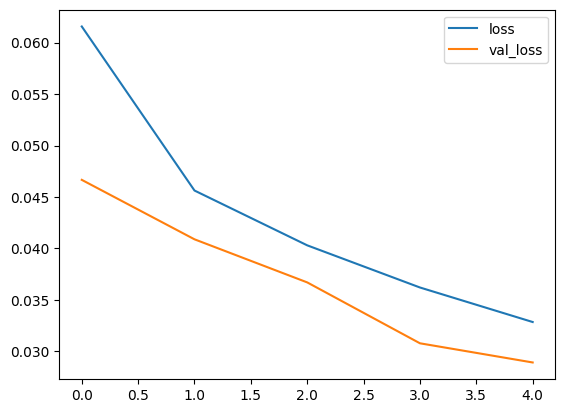

In [30]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [31]:
input_text = vectorizer('You really suck')

In [32]:
batch = test.as_numpy_iterator().next()

2023-08-29 21:32:28.017350: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2297822400 exceeds 10% of free system memory.


In [33]:
res=model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 819ms/step


In [34]:
res

array([[0.9982558 , 0.08334956, 0.9850788 , 0.0024539 , 0.7731332 ,
        0.01308001]], dtype=float32)

In [35]:
from tensorflow.keras.metrics import Precision, Recall

In [36]:
pre = Precision()
re = Recall()

In [37]:
for batch in test.as_numpy_iterator():
    #Unpacking Batch
    X_true,y_true=batch
    #Making Prediction
    yhat = model.predict(X_true)
    #Flatten Predictions
    y_true = y_true.flatten()
    yhat=yhat.flatten()
    #
    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)

1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


In [38]:
model.save('toxic.h5')

In [40]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}')

Precision: 0.8600357174873352, Recall:0.8315577507019043, Accuracy:0.4974924921989441
